In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from shapely.geometry import Point, Polygon
import geopandas as gpd
import random

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [2]:
# firm location generation
def Random_Points_in_Polygon(polygon, number):
    points = []
    temp = polygon.bounds
    counter = 0
#     print(minx, miny, maxx, maxy)
    while counter < number:
        pnt = Point(random.uniform(temp.minx.values[0], temp.maxx.values[0]), random.uniform(temp.miny, temp.maxy.values[0]))
#         print(pnt.within(polygon))
#         print(pnt)
#         print(polygon)
        if polygon.contains(pnt).all():
            points.append(pnt)
            counter += 1
    return points

In [2]:
# vehicle assignment function
def veh_type_simulator(n_truck, vehicle_type_fraction): # Simulate mode choice
    choice = np.random.multinomial(n_truck, vehicle_type_fraction, size = 1)
    choice = pd.Series(choice[0])
#     print(choice)
    return(choice)

def split_dataframe(df, chunk_size = 100000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [4]:
# generate firm location
output_dir = 'outputs_aus_2050'
firm_name = 'forecasted_firms.csv'
firms = read_csv(output_dir + '/' + firm_name)
zonal_shapefile = gpd.read_file('inputs/Austin_freight.geojson')
print(zonal_shapefile.columns)

Index(['GEOID', 'CBPZONE', 'MESOZONE', 'geometry'], dtype='object')


In [ ]:
# print(firms.columns)
unique_zones = firms.MESOZONE.unique()
firms_with_location = None
for zone in unique_zones:
#     print(zone)
    firms_within_zone = firms.loc[firms['MESOZONE'] == zone]
    sample_size = len(firms_within_zone)
    zonal_polygon = \
    zonal_shapefile.loc[zonal_shapefile['MESOZONE'] == zone]
    
    points = Random_Points_in_Polygon(zonal_polygon, sample_size)
    points_df = pd.DataFrame(points, columns = ['geometry'])
    points_gdf = gpd.GeoDataFrame(points_df) 
    points_gdf.loc[:, 'lat'] = points_gdf.geometry.y
    points_gdf.loc[:, 'lon'] = points_gdf.geometry.x
    points_out = pd.DataFrame(points_gdf.drop(columns='geometry'))
    firms_within_zone = pd.concat([firms_within_zone.reset_index(), 
                                   points_out.reset_index()], 
                                  axis = 1)
    firms_with_location = pd.concat([firms_with_location, firms_within_zone])
#     break
firms_with_location.to_csv(output_dir + '/forecasted_firms_with_location.csv', index = False)
firms_with_location.head(5)

8453392
8453392


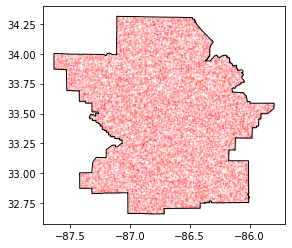

In [5]:
print(len(firms.BusID.unique()))
print(len(firms))
points_df = pd.DataFrame(points, columns = ['geometry'])
# points_df.to_csv(output_dir + '/points_troubleshoot.csv')
points_gdf = gpd.GeoDataFrame(points_df)  
# lat = points_gdf.geometry.y
# lon = points_gdf.geometry.x
# print(lat)
base = zonal_polygon.boundary.plot(linewidth=1, edgecolor="black")
points_gdf.plot(ax=base, linewidth=1, color="red", alpha = 0.1, markersize=0.5)
plt.show()
# xp,yp = zonal_polygon.exterior.xy
# plt.plot(xp,yp)

# # Plot the list of points
# xs = [point.x for point in points]
# ys = [point.y for point in points]
# plt.scatter(xs, ys,color="red")
# plt.show()

In [2]:
scenario_name = 'TDA_low'
output_dir = 'outputs_aus_2050'
firm_name = 'forecast_firms_with_location.csv'
firms = read_csv(output_dir + '/' + firm_name)
private_fleet = read_csv('inputs/fleet/TX_private_fleet_size_distribution_V2.csv')
for_hire_fleet = read_csv('inputs/fleet/TX_for_hire_fleet_size_distribution_V2.csv')
for_lease_fleet = read_csv('inputs/fleet/TX_for_lease_fleet_size_distribution_V2.csv')
cargo_type_distribution = read_csv("inputs/fleet/probability_of_cargo_group.csv")

# forecast values
national_fleet_composition = read_csv('inputs/fleet/' + scenario_name + '/TDA_vehicle_stock.csv')
vehicle_type_by_state = read_csv('inputs/fleet/' + scenario_name + '/fleet_composition_by_state.csv')
ev_fraction = read_csv('inputs/fleet/' + scenario_name + '/EV_fraction_by_type.csv')
ev_availability = read_csv('inputs/fleet/' + scenario_name + '/EV_availability.csv')

state_fips_lookup = read_csv('inputs/us-state-ansi-fips.csv')
# vehicle_type_fraction = [0.206287,	0.505178, 0.244464, 0.044071]  # will be replaced once input from Alicia is ready

In [3]:
# filter vehicle composition data
analysis_year = 2018
vehicle_type_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Year'] == analysis_year]

national_fleet_composition = \
national_fleet_composition.loc[national_fleet_composition['Year'] == analysis_year]

ev_fraction = ev_fraction.loc[ev_fraction['Year'] == analysis_year]

ev_availability = ev_availability.loc[ev_availability['Year'] == analysis_year]

ev_availability.head(5)

,Year,vehicle type,Powertrain,Stock,EV_fraction
0,2018,Class 4-6 Vocational,Battery Electric,101.0,1.0
1,2018,Class 4-6 Vocational,H2 Fuel Cell,0.0,0.0
2,2018,Class 4-6 Vocational,PHEV Diesel,0.0,0.0
3,2018,Class 4-6 Vocational,PHEV Gasoline,0.0,0.0
4,2018,Class 7&8 Tractor,Battery Electric,6.0,1.0


In [4]:
# format fleet composition
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()

private_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'PRIVATE']
private_fleet_by_state_wide = pd.pivot_table(private_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
private_fleet_by_state_wide = private_fleet_by_state_wide.reset_index()


for_hire_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'FOR HIRE']
for_hire_fleet_by_state_wide = pd.pivot_table(for_hire_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_hire_fleet_by_state_wide = for_hire_fleet_by_state_wide.reset_index()


for_lease_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'LEASE']
for_lease_fleet_by_state_wide = pd.pivot_table(for_lease_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_lease_fleet_by_state_wide = for_lease_fleet_by_state_wide.reset_index()

private_fleet_by_state_wide.head(5)

vehicle category,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,ALABAMA,0.243046,0.303801,0.282828,0.000012,6.467405e-07,2.889022e-07,0.169764
1,ALASKA,0.275343,0.221711,0.309854,0.000014,4.719849e-07,3.165081e-07,0.192323
2,ARIZONA,0.274482,0.308356,0.224665,0.000013,6.564382e-07,2.294897e-07,0.191722
3,ARKANSAS,0.158329,0.538997,0.191483,0.000008,1.147434e-06,1.955959e-07,0.110591
4,CALIFORNIA,0.279156,0.327610,0.197732,0.000014,6.974263e-07,2.019784e-07,0.194987


8461670
8461670


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std,n_trucks
0,0-2,1,0.709745,1.218434,0.413643,2
0,0-2,1,0.709745,1.218434,0.413643,2
1,3-5,3,0.154389,3.692529,0.778908,3
0,0-2,1,0.709745,1.218434,0.413643,2
0,0-2,1,0.709745,1.218434,0.413643,1


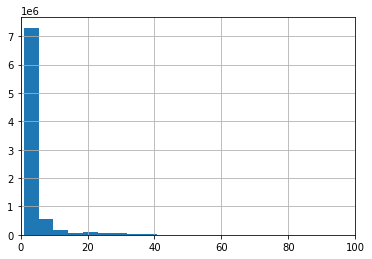

In [5]:
sample_size = len(firms)
print(sample_size)
# print(tx_private_fleet.columns)
private_fleet_short = private_fleet[['fleet_size', 'min_size', 
                                    'fraction_of_carrier', 
                                    'avg_truck_per_carrier', 
                                    'total_truck_std']]

firm_fleet_sample = \
private_fleet_short.sample(n = sample_size,
                           weights = private_fleet_short['fraction_of_carrier'],
                           replace = True)
print(len(firm_fleet_sample))
# generate random fleet size
firm_fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = firm_fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = firm_fleet_sample.loc[:, 'total_truck_std'])
criteria = (firm_fleet_sample['n_trucks'] <= firm_fleet_sample['min_size'])
firm_fleet_sample.loc[criteria, 'n_trucks'] = firm_fleet_sample.loc[criteria, 'min_size']
firm_fleet_sample.loc[:, 'n_trucks'] = np.round(firm_fleet_sample.loc[:, 'n_trucks'], 0)
firm_fleet_sample.loc[:, 'n_trucks'] = firm_fleet_sample.loc[:, 'n_trucks'].astype(int)

firm_fleet_sample['n_trucks'].hist(bins = 1000)
plt.xlim([0,100])
firm_fleet_sample.head(5)

In [6]:
# append vehicle composition to firms by state
firm_fleet_sample = firm_fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
firms = firms.sort_values(by = ['Emp'], ascending = True)

firm_fleet_sample_short = firm_fleet_sample[['n_trucks']]

firms_with_fleet = pd.concat([firms.reset_index(drop=True), 
                              firm_fleet_sample_short.reset_index(drop=True)], axis=1)

firms_with_fleet.loc[:, 'FAFZONE'] = firms_with_fleet.loc[:,'FAFZONE'].astype(str).str.zfill(3)
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'FAFZONE'].str[:2]
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'st'].astype(int)

firms_with_fleet = pd.merge(firms_with_fleet, state_fips_lookup,
                            on = 'st', how = 'left')

firms_with_fleet.loc[:,'stname'] = firms_with_fleet.loc[:,'stname'].str.upper()

firms_with_fleet = pd.merge(firms_with_fleet, private_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

firms_with_fleet.head(5)

,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MASSACHUSETTS,MA,MASSACHUSETTS,0.317864,0.137498,0.322429,0.000016,2.927105e-07,3.293537e-07,0.222023
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GEORGIA,GA,GEORGIA,0.277786,0.309447,0.218503,0.000014,6.587605e-07,2.231957e-07,0.194030
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IOWA,IA,IOWA,0.126859,0.511540,0.272772,0.000006,1.088982e-06,2.786298e-07,0.088609
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0.554441,0.009534,0.048729,0.000027,2.029602e-08,4.977529e-08,0.387269
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0.554441,0.009534,0.048729,0.000027,2.029602e-08,4.977529e-08,0.387269


In [8]:
# assign vehicle technology
chunks = split_dataframe(firms_with_fleet)
i = 0
for chunk in chunks:
    print('processing chunk ' + str(i))
    chunk[list_of_veh_tech] = \
    chunk.apply(
            lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
    # print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
    if i==0:
        firms_with_fleet = chunk
    else:
        firms_with_fleet = pd.concat([firms_with_fleet, chunk])
    i += 1
firms_with_fleet.head(5)

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9
processing chunk 10
processing chunk 11
processing chunk 12
processing chunk 13
processing chunk 14
processing chunk 15
processing chunk 16
processing chunk 17
processing chunk 18
processing chunk 19
processing chunk 20
processing chunk 21
processing chunk 22
processing chunk 23
processing chunk 24
processing chunk 25
processing chunk 26
processing chunk 27
processing chunk 28
processing chunk 29
processing chunk 30
processing chunk 31
processing chunk 32
processing chunk 33
processing chunk 34
processing chunk 35
processing chunk 36
processing chunk 37
processing chunk 38
processing chunk 39
processing chunk 40
processing chunk 41
processing chunk 42
processing chunk 43
processing chunk 44
processing chunk 45
processing chunk 46
processing chunk 47
processing chunk 48
processing chunk 49
processing

,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MASSACHUSETTS,MA,MASSACHUSETTS,0,0,0,0,0,0,0
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GEORGIA,GA,GEORGIA,0,0,0,0,0,0,0
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IOWA,IA,IOWA,0,0,0,0,0,0,0
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0


In [9]:
# processing carriers
firms_with_fleet['Industry_NAICS6_Make'] = firms_with_fleet['Industry_NAICS6_Make'].astype(str)
new_firms = firms_with_fleet[['esizecat', 'CBPZONE', 'FAFZONE',
                              'Industry_NAICS6_Make', 'Commodity_SCTG',	
                              'Emp', 'BusID', 'MESOZONE', 'lat', 'lon',
                              'stname', 'st']]


carriers = new_firms.loc[new_firms['Industry_NAICS6_Make'].isin(['492000', '484000'])]
print(carriers['Industry_NAICS6_Make'].unique())
sample_size = len(carriers)
# print(tx_private_fleet.columns)
for_hire_fleet_short = for_hire_fleet[['fleet_size', 'min_size', 
                                           'fraction_of_carrier', 
                                           'avg_truck_per_carrier', 
                                           'total_truck_std']]

fleet_sample = for_hire_fleet_short.sample(n = sample_size,
                                            weights = for_hire_fleet_short['fraction_of_carrier'],
                                            replace = True)
print(len(fleet_sample))
fleet_sample.head(5)
                                                        

['492000' '484000']
159980


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std
0,0-2,1,0.676541,1.233709,0.423566
1,3-5,3,0.166138,3.708408,0.781045
1,3-5,3,0.166138,3.708408,0.781045
0,0-2,1,0.676541,1.233709,0.423566
0,0-2,1,0.676541,1.233709,0.423566


In [10]:
fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = fleet_sample.loc[:, 'total_truck_std'])
criteria = (fleet_sample['n_trucks'] <= fleet_sample['min_size'])
fleet_sample.loc[criteria, 'n_trucks'] = fleet_sample.loc[criteria, 'min_size']
fleet_sample.loc[:, 'n_trucks'] = np.round(fleet_sample.loc[:, 'n_trucks'], 0)
fleet_sample.loc[:, 'n_trucks'] = fleet_sample.loc[:, 'n_trucks'].astype(int)
# fleet_sample.head(5)
fleet_sample = fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
carriers = carriers.sort_values(by = ['Emp'], ascending = True)

fleet_sample_short = fleet_sample[['n_trucks']]

carriers_with_fleet = pd.concat([carriers.reset_index(drop=True), 
                                 fleet_sample_short.reset_index(drop=True)], axis=1)

carriers_with_fleet = pd.merge(carriers_with_fleet, for_hire_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

carriers_with_fleet[list_of_veh_tech] = \
carriers_with_fleet.apply(
        lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
# print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
carriers_with_fleet.head(5)


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,st,n_trucks,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,1,49,222,492000,0,0.012807,8442331,20049,29.823220,-93.721271,...,22,1,LOUISIANA,0,1,0,0,0,0,0
1,1,48001,489,492000,0,0.012807,2877133,6,31.781069,-95.621497,...,48,1,TEXAS,0,1,0,0,0,0,0
2,1,48001,489,492000,0,0.012807,2877134,35,31.630904,-95.575748,...,48,1,TEXAS,0,1,0,0,0,0,0
3,1,48027,489,492000,0,0.012807,2876123,373,31.108142,-97.749684,...,48,1,TEXAS,0,1,0,0,0,0,0
4,1,48041,489,492000,0,0.017367,2886569,1671,30.595009,-96.325727,...,48,1,TEXAS,0,0,0,0,0,0,1


In [11]:
# assign cargo type for each carrier
unique_cargo = cargo_type_distribution.Cargo.unique()
for cargo in unique_cargo:
    fraction = \
    cargo_type_distribution.loc[cargo_type_distribution['Cargo'] == cargo, 'probability']
    carriers_with_fleet.loc[:, cargo] = np.random.binomial(1, fraction, sample_size)
carriers_with_fleet.head(5)
carriers_with_fleet.loc[:, 'cargo_check'] = carriers_with_fleet.loc[:, unique_cargo].sum(axis = 1)
carriers_with_fleet.loc[carriers_with_fleet['cargo_check'] == 0, 'other_cargo'] = 1

sctg1_cargo = ['construction_material', 'farm_product', 'large_equipment', 'other_bulk', 'other_cargo']
sctg2_cargo = ['farm_product', 'chemical', 'other_cargo']
sctg3_cargo = ['food', 'farm_product', 'other_bulk', 'other_cargo']
sctg4_cargo = ['construction_material', 'vehicle_home', 'large_equipment', 
               'other_bulk', 'household', 'other_cargo']
sctg5_cargo = ['garbage', 'other_bulk', 'intermodal_container', 'other_cargo']

carriers_with_fleet.loc[:, 'SCTG1'] = carriers_with_fleet.loc[:, sctg1_cargo].sum(axis = 1)
carriers_with_fleet.loc[:, 'SCTG2'] = carriers_with_fleet.loc[:, sctg2_cargo].sum(axis = 1)
carriers_with_fleet.loc[:, 'SCTG3'] = carriers_with_fleet.loc[:, sctg3_cargo].sum(axis = 1)
carriers_with_fleet.loc[:, 'SCTG4'] = carriers_with_fleet.loc[:, sctg4_cargo].sum(axis = 1)
carriers_with_fleet.loc[:, 'SCTG5'] = carriers_with_fleet.loc[:, sctg5_cargo].sum(axis = 1)

carriers_with_fleet.loc[carriers_with_fleet['SCTG1'] > 1, 'SCTG1'] = 1
carriers_with_fleet.loc[carriers_with_fleet['SCTG2'] > 1, 'SCTG2'] = 1
carriers_with_fleet.loc[carriers_with_fleet['SCTG3'] > 1, 'SCTG3'] = 1
carriers_with_fleet.loc[carriers_with_fleet['SCTG4'] > 1, 'SCTG4'] = 1
carriers_with_fleet.loc[carriers_with_fleet['SCTG5'] > 1, 'SCTG5'] = 1

carriers_with_fleet = carriers_with_fleet.drop(columns=['cargo_check'])
carriers_with_fleet.head(5)

,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,garbage,other_bulk,household,intermodal_container,other_cargo,SCTG1,SCTG2,SCTG3,SCTG4,SCTG5
0,1,49,222,492000,0,0.012807,8442331,20049,29.823220,-93.721271,...,0,0,0,0,1,1,1,1,1,1
1,1,48001,489,492000,0,0.012807,2877133,6,31.781069,-95.621497,...,0,1,0,0,0,1,0,1,1,1
2,1,48001,489,492000,0,0.012807,2877134,35,31.630904,-95.575748,...,0,0,0,0,1,1,1,1,1,1
3,1,48027,489,492000,0,0.012807,2876123,373,31.108142,-97.749684,...,0,0,0,0,1,1,1,1,1,1
4,1,48041,489,492000,0,0.017367,2886569,1671,30.595009,-96.325727,...,1,0,0,0,0,1,1,1,1,1


In [12]:
leasing = new_firms.loc[new_firms['Industry_NAICS6_Make'].isin(['532100'])]
sample_size = len(leasing)
# print(tx_private_fleet.columns)
for_lease_fleet_short = for_lease_fleet[['fleet_size', 'min_size', 
                                           'fraction_of_carrier', 
                                           'avg_truck_per_carrier', 
                                           'total_truck_std']]

fleet_sample = for_lease_fleet_short.sample(n = sample_size,
                                            weights = for_lease_fleet_short['fraction_of_carrier'],
                                            replace = True)
print(len(fleet_sample))
fleet_sample.head(5)

fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = fleet_sample.loc[:, 'total_truck_std'])
criteria = (fleet_sample['n_trucks'] <= fleet_sample['min_size'])
fleet_sample.loc[criteria, 'n_trucks'] = fleet_sample.loc[criteria, 'min_size']
fleet_sample.loc[:, 'n_trucks'] = np.round(fleet_sample.loc[:, 'n_trucks'], 0)
fleet_sample.loc[:, 'n_trucks'] = fleet_sample.loc[:, 'n_trucks'].astype(int)
# fleet_sample.head(5)
fleet_sample = fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
leasing = leasing.sort_values(by = ['Emp'], ascending = True)

fleet_sample_short = fleet_sample[['n_trucks']]

leasing_with_fleet = pd.concat([leasing.reset_index(drop=True), 
                              fleet_sample_short.reset_index(drop=True)], axis=1)

leasing_with_fleet = pd.merge(leasing_with_fleet, for_lease_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

leasing_with_fleet[list_of_veh_tech] = \
leasing_with_fleet.apply(
        lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
# print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))

leasing_with_fleet.head(5)

16535


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,st,n_trucks,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,1,28,131,532100,0,0.026883,3849503,20028,34.209257,-84.613001,...,13,1,GEORGIA,1,0,0,0,0,0,0
1,1,28,131,532100,0,0.026883,3849505,20028,32.967913,-84.652635,...,13,1,GEORGIA,0,0,1,0,0,0,0
2,1,28,131,532100,0,0.026883,3849504,20028,33.830995,-84.565283,...,13,1,GEORGIA,0,1,0,0,0,0,0
3,1,28,131,532100,0,0.026883,3849502,20028,33.463004,-83.936809,...,13,1,GEORGIA,0,1,0,0,0,0,0
4,1,61,271,532100,0,0.036648,3849686,20061,44.396436,-93.743633,...,27,1,MINNESOTA,0,1,0,0,0,0,0


In [13]:
# post-processing results
# firms_with_fleet['Industry_NAICS6_Make'] = firms_with_fleet['Industry_NAICS6_Make'].astype(str)
firms_with_fleet = \
firms_with_fleet[~firms_with_fleet['Industry_NAICS6_Make'].isin(['492000', '484000', '532100'])]
print(len(firms_with_fleet))
# firms_with_fleet.loc[:, list_of_veh_tech] = 1
firms_with_fleet.head(5)

8285155


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MASSACHUSETTS,MA,MASSACHUSETTS,0,0,0,0,0,0,0
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GEORGIA,GA,GEORGIA,0,0,0,0,0,0,0
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IOWA,IA,IOWA,0,0,0,0,0,0,0
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0


In [14]:
# adjust the total fleet

# national_fleet_composition.head(5)
firm_fleet_agg = firms_with_fleet.loc[:, list_of_veh_tech].sum()
firm_fleet_agg = firm_fleet_agg.to_frame()
firm_fleet_agg = firm_fleet_agg.reset_index()
firm_fleet_agg.columns = ['vehicle_type', 'total']
firm_fleet_agg.loc[:, 'source'] = 'firms'


carrier_fleet_agg = carriers_with_fleet.loc[:, list_of_veh_tech].sum()
carrier_fleet_agg = carrier_fleet_agg.to_frame()
carrier_fleet_agg = carrier_fleet_agg.reset_index()
carrier_fleet_agg.columns = ['vehicle_type', 'total']
carrier_fleet_agg.loc[:, 'source'] = 'carrier'

lease_fleet_agg = leasing_with_fleet.loc[:, list_of_veh_tech].sum()
lease_fleet_agg = lease_fleet_agg.to_frame()
lease_fleet_agg = lease_fleet_agg.reset_index()
lease_fleet_agg.columns = ['vehicle_type', 'total']
lease_fleet_agg.loc[:, 'source'] = 'lease'

modeled_fleet_agg = pd.concat([firm_fleet_agg, carrier_fleet_agg, lease_fleet_agg])
modeled_fleet_agg.head(5)

,vehicle_type,total,source
0,Diesel Class 4-6 Vocational,10414553,firms
1,Electric Class 4-6 Vocational,557,firms
2,Gasoline Class 4-6 Vocational,7274181,firms
3,Diesel Class 7&8 Tractor,12271805,firms
4,Electric Class 7&8 Tractor,25,firms


In [15]:
# calculate the scaling factor
total_modeled_veh = pd.pivot_table(modeled_fleet_agg, values='total', 
                                   index=['vehicle_type'], columns=['source'], aggfunc=np.sum)
total_modeled_veh = total_modeled_veh.reset_index()
# total_modeled_veh.head(5)

total_modeled_veh = total_modeled_veh.reset_index()
print(national_fleet_composition.columns)
national_fleet_adj = pd.merge(national_fleet_composition, 
                              total_modeled_veh,
                              left_on = 'vehicle category',
                              right_on = 'vehicle_type', how = 'left')
national_fleet_adj.loc[:, 'private_stock'] = national_fleet_adj.loc[:, 'Stock'] - \
national_fleet_adj.loc[:, 'carrier'] - national_fleet_adj.loc[:, 'lease'] 
national_fleet_adj.loc[:, 'adj_factor'] = national_fleet_adj.loc[:, 'private_stock'] / \
national_fleet_adj.loc[:, 'firms']
national_fleet_adj.head(5)                                                            

Index(['Year', 'vehicle type', 'fuel type', 'Stock', 'VMT_millions',
       'vehicle category', 'Fraction'],
      dtype='object')


,Year,vehicle type,fuel type,Stock,VMT_millions,vehicle category,Fraction,index,vehicle_type,carrier,firms,lease,private_stock,adj_factor
0,2018,Class 4-6 Vocational,Diesel,2059238.0,37818.891867,Diesel Class 4-6 Vocational,0.588743,0,Diesel Class 4-6 Vocational,73940,10414553,99682,1885616.0,0.181056
1,2018,Class 4-6 Vocational,Electric,101.0,2.274845,Electric Class 4-6 Vocational,0.000029,3,Electric Class 4-6 Vocational,2,557,2,97.0,0.174147
2,2018,Class 4-6 Vocational,Gasoline,1438348.0,18945.786780,Gasoline Class 4-6 Vocational,0.411228,6,Gasoline Class 4-6 Vocational,51987,7274181,69181,1317180.0,0.181076
3,2018,Class 7&8 Tractor,Diesel,2818447.0,140459.832888,Diesel Class 7&8 Tractor,0.999998,1,Diesel Class 7&8 Tractor,648813,12271805,171931,1997703.0,0.162788
4,2018,Class 7&8 Tractor,Electric,6.0,0.128614,Electric Class 7&8 Tractor,0.000002,4,Electric Class 7&8 Tractor,2,25,0,4.0,0.160000


In [16]:
# adjust firm fleet only
for vt in list_of_veh_tech:
#     print(vt)
    adj_factor = \
    national_fleet_adj.loc[national_fleet_adj['vehicle_type'] == vt, 'adj_factor']
    adj_factor = float(adj_factor)
#     print(adj_factor)
    firms_with_fleet.loc[:, vt] *= adj_factor
    firms_with_fleet.loc[:, vt] = np.round(firms_with_fleet.loc[:, vt], 0)
    firms_with_fleet.loc[:, vt] = firms_with_fleet.loc[:, vt].fillna(0)
    firms_with_fleet.loc[:, vt] = firms_with_fleet.loc[:, vt].astype(int)

print(firms_with_fleet.loc[:, list_of_veh_tech].sum())
firms_with_fleet.loc[:, 'n_trucks'] = firms_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)
firms_with_fleet.head(5)


Diesel Class 4-6 Vocational      1387728
Electric Class 4-6 Vocational          0
Gasoline Class 4-6 Vocational     914407
Diesel Class 7&8 Tractor         1300560
Electric Class 7&8 Tractor             0
Diesel Class 7&8 Vocational      1101920
Electric Class 7&8 Vocational          0
dtype: int64


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MASSACHUSETTS,MA,MASSACHUSETTS,0,0,0,0,0,0,0
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GEORGIA,GA,GEORGIA,0,0,0,0,0,0,0
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IOWA,IA,IOWA,0,0,0,0,0,0,0
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DISTRICT OF COLUMBIA,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0


In [17]:
# assign EV type
# print(ev_fraction)

# carriers_with_fleet.loc[:, 'n_trucks'] = carriers_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)
# leasing_with_fleet.loc[:, 'n_trucks'] = leasing_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)

powertrain = ev_fraction.Powertrain.to_numpy()
print(powertrain)
probability = ev_fraction.EV_fraction.to_numpy()

sample_size = len(firms_with_fleet)
firms_with_fleet.loc[:, 'EV_powertrain (if any)'] = \
pd.Series(np.random.choice(powertrain, size = sample_size, p=probability) ) 

sample_size = len(carriers_with_fleet)
carriers_with_fleet.loc[:, 'EV_powertrain (if any)'] = \
pd.Series(np.random.choice(powertrain, size = sample_size, p=probability) ) 

sample_size = len(leasing_with_fleet)
leasing_with_fleet.loc[:, 'EV_powertrain (if any)'] = \
pd.Series(np.random.choice(powertrain, size = sample_size, p=probability) ) 
# carriers_with_fleet.head(5)

firms_with_fleet.head(5)

['Battery Electric' 'H2 Fuel Cell' 'PHEV Diesel' 'PHEV Gasoline']


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MA,MASSACHUSETTS,0,0,0,0,0,0,0,Battery Electric
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GA,GEORGIA,0,0,0,0,0,0,0,Battery Electric
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IA,IOWA,0,0,0,0,0,0,0,Battery Electric
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0,Battery Electric
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0,Battery Electric


In [18]:
firms_with_fleet.loc[firms_with_fleet['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'
carriers_with_fleet.loc[carriers_with_fleet['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'
leasing_with_fleet.loc[leasing_with_fleet['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'

In [19]:
# writing output
firms_with_fleet.to_csv(output_dir + '/' + str(analysis_year) + '/forecast_firms_with_fleet_'+ scenario_name + '.csv')
carriers_with_fleet.to_csv(output_dir + '/' + str(analysis_year) + '/forecast_carriers_'+ scenario_name + '.csv')
leasing_with_fleet.to_csv(output_dir + '/' + str(analysis_year) + '/forecast_leasing_company_'+ scenario_name + '.csv')